In [3]:
import numpy as np
import os
import sys
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import ops as utils_ops
from pathlib import Path
%matplotlib inline

In [4]:
sys.path.append('../models/research/object_detection/')
from utils import label_map_util
from utils import visualization_utils as vis_util

# Load model

In [5]:
# Load model
PATH_TO_CKPT = 'pet_detector/exported_graphs/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [8]:
# Load labels
PATH_TO_LABELS = 'pet_detector/pet_label_map.pbtxt'
NUM_CLASSES = 37
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Methods

In [10]:
def load_image_into_numpy_array(image):
    im_width, im_height = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

def show_npimg(x, figsize=None):
    if figsize: plt.figure(figsize=figsize)
    plt.imshow(x)
    plt.axis('off')
    plt.show()
    
def process_image(x, show_original=True, show_result=True, figsize=None):
    image = Image.open(x)
    image_np = load_image_into_numpy_array(image)
    if show_original: show_npimg(image_np, figsize)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    output_dict = run_inference_for_single_image(image_np, detection_graph)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    
    if show_result: show_npimg(image_np, figsize)
    
    return image_np, output_dict

# Detection

In [33]:
img_folder = Path('pet_detector/images/')
imgs = [f for f in img_folder.iterdir() if f.suffix == '.jpg']

pet_detector/images/wheaten_terrier_22.jpg


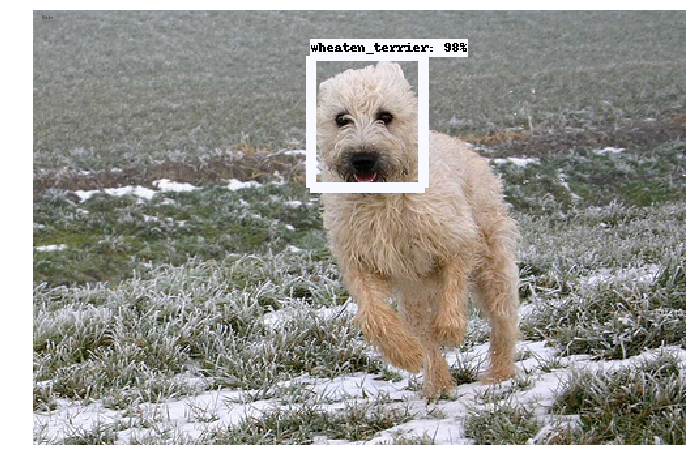

In [52]:
choice = np.random.choice(imgs)
print(choice)
res_img, res_details = process_image(choice, show_original=False, figsize=(12,8))

In [53]:
res_details.keys()

dict_keys(['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes'])

In [54]:
res_details['detection_boxes'].shape, res_details['detection_boxes'][0]

((300, 4),
 array([0.10699294, 0.42594522, 0.40800893, 0.59801227], dtype=float32))

In [55]:
res_details['detection_scores'][:5], res_details['detection_classes'][:5]

(array([0.98764205, 0.08967465, 0.02477688, 0.00910082, 0.00907038],
       dtype=float32), array([36, 16, 31, 19, 17], dtype=uint8))

In [56]:
[c for c in categories if c['id'] in res_details['detection_classes'][:5]]

[{'id': 16, 'name': 'great_pyrenees'},
 {'id': 17, 'name': 'havanese'},
 {'id': 19, 'name': 'keeshond'},
 {'id': 31, 'name': 'scottish_terrier'},
 {'id': 36, 'name': 'wheaten_terrier'}]